# VIX Trading Strategy

In [14]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import math

In [15]:
def fetch_data(string1, string2, string3, filename):
    w = quandl.get(string1, authtoken = string2, start_date = string3)
    w.to_csv(filename)
    w = pd.read_csv(filename)
    return w

In [16]:
# S&P500 future data fetch from "CHRIS/CME_SP1" database
Data1 = fetch_data("CHRIS/CME_SP1", "U_Gp39gZutpHmaFgC65Y","2014-12-12", "local_future.csv")
Data = fetch_data("CBOE/VIX", "U_Gp39gZutpHmaFgC65Y", "2014-12-12", "VIX_data.csv")
Data['future'] = Data1['Last']
Data['VIX'] = Data['VIX Close']

In [17]:
Data.head(2)

,Date,VIX Open,VIX High,VIX Low,VIX Close,future,VIX
0,2014-12-12,20.51,23.06,18.34,21.08,1997.5,21.08
1,2014-12-15,19.59,24.83,17.77,20.42,1991.0,20.42


In [18]:
mtm = list()
order_details = list()
order = list()#.........................a list which stores the transactions ( -1:"BUY" , 1:"SELL" , 0:"DO NOTHING")
profit = list()
buy_sell = list() #.....................a list which tells buy/sell in words!
stoploss = list()
pro = 0 # profit( which happens( +/-) at the end of each transaction )
v=0 #.................................. V is the buying price and 3/4 % above v will be the selling price
thresh = 22  #..........................VIX threshold for placing a buy order 
change_1 = 5 #..........................% above which to sell for a profit
change_2 = 5 #..........................% below which to sell in a stoploss
buy_flag = False#.......................indicates if last order was a buy 
sell_flag = True # ....................indicates if last order is a sell
s = Data['future'].size#................size of the VIX dataset
c_1 = (1 + (change_1)/float(100) ) #....c_1 is the value above which the sell order will execute in a successful trade
c_2 = (1 - (change_2)/float(100) ) #....c_2 is the value below which a sell order will execute in  a stoploss

Text(0,0.5,'S&P500 futures')

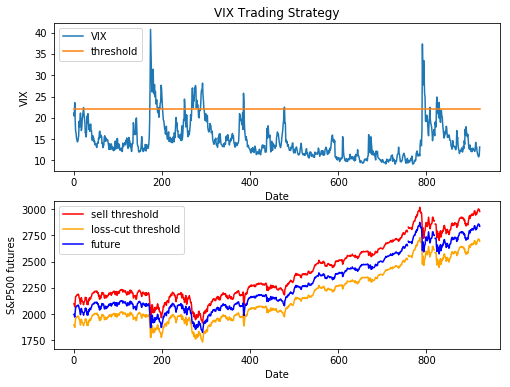

In [21]:
sell_threshold = c_1 * Data['future']
losscut_threshold = c_2 * Data['future']

plt.figure(figsize=(8, 6))
plt.subplot(2,1,1)
plt.plot(Data.index, Data['VIX'], label="VIX")
plt.plot([Data.index[0], Data.index[-1]], [thresh, thresh], label='threshold')
plt.legend()
plt.title('VIX Trading Strategy')
plt.xlabel('Date')
plt.ylabel('VIX')

plt.subplot(2,1,2)
plt.plot(sell_threshold, label='sell threshold', color='red')
plt.plot(losscut_threshold, label='loss-cut threshold', color='orange')
plt.plot(Data['future'], 'b')
plt.legend()
plt.xlabel('Date')
plt.ylabel('S&P500 futures')

In [22]:
for i in range(s):
    pro = 0

    if(Data['VIX'][i] >=thresh and (not buy_flag)):          #........IF THRESHOLD IS CROSSED THEN "BUY" the S&P500 futures
        order_details = [-1,"Buy" , "0", "position taken"]
        buy_flag = True
        sell_flag =False
        v = Data['future'][i]                                           #..............................PRICE AT WHICH WE "BUY"  

    elif(Data['future'][i] >= (c_1)*v and (not sell_flag)):#...IF future price is c_1 times v, then "SELL" ( profit )
        buy_flag = False
        sell_flag = True
        pro = (Data['future'][i] - v) #profit= (selling price - the buying price)
        order_details = [1,"Sell" , "0", "position closed"]  
        
    elif(Data['future'][i] <= (c_2)*v and (not sell_flag)):#...IF future price is c_2 times v , then "SELL" ( loss )
        buy_flag = False
        sell_flag = True
        pro = (Data['future'][i] - v)
        order_details = [1,"Sell" , "Stoploss executed", "position closed"] 
    else:
        if(buy_flag ==1): x = (Data['future'][i] - v ) * 500* 2
        else: x = "0"
        order_details = [0,"No trade" , "0", x]
        
    profit.append(pro)
    order.append(order_details[0])
    buy_sell.append(order_details[1])
    stoploss.append(order_details[2])
    mtm.append(order_details[3])

In [23]:
Data['stoploss'] = pd.Series()
Data['mtm'] = pd.Series(mtm)
Data['placed_order'] = pd.Series(order)
Data['stoploss'] = pd.Series(stoploss)
Data['buy_sell'] = pd.Series(buy_sell)
Data['profit'] = pd.Series(profit) *500*2
Data['cost'] = (Data['placed_order'].multiply(Data['future'])) *500*2 #the cost at each transaction : buy/sell * (future price)
Data['out'] = Data['cost'].cumsum() # out is the cumulative cost... profit/loss after transactions till now
print (Data['out'])

0            0.0
1            0.0
2     -1971200.0
3     -1971200.0
4     -1971200.0
5     -1971200.0
6       101300.0
7       101300.0
8       101300.0
9       101300.0
10      101300.0
11      101300.0
12      101300.0
13      101300.0
14      101300.0
15      101300.0
16      101300.0
17      101300.0
18      101300.0
19      101300.0
20      101300.0
21      101300.0
22    -1887900.0
23    -1887900.0
24    -1887900.0
25    -1887900.0
26    -1887900.0
27    -1887900.0
28    -1887900.0
29    -1887900.0
         ...    
892   -2140900.0
893   -2140900.0
894   -2140900.0
895   -2140900.0
896   -2140900.0
897   -2140900.0
898   -2140900.0
899   -2140900.0
900   -2140900.0
901   -2140900.0
902   -2140900.0
903   -2140900.0
904     674100.0
905     674100.0
906     674100.0
907     674100.0
908     674100.0
909     674100.0
910     674100.0
911     674100.0
912     674100.0
913     674100.0
914     674100.0
915     674100.0
916     674100.0
917     674100.0
918     674100.0
919     674100

In [24]:
Data[Data['profit'] > 0]

,Date,VIX Open,VIX High,VIX Low,VIX Close,future,VIX,stoploss,mtm,placed_order,buy_sell,profit,cost,out
6,2014-12-22,16.32,16.88,15.03,15.25,2072.5,15.25,0,position closed,1,Sell,101300.0,2072500.0,101300.0
42,2015-02-13,15.11,15.64,14.69,14.69,2093.0,14.69,0,position closed,1,Sell,103800.0,2093000.0,205100.0
177,2015-08-27,27.11,29.90,24.49,26.10,1989.3,26.10,0,position closed,1,Sell,117800.0,1989300.0,223400.0
203,2015-10-05,20.31,20.42,19.14,19.54,1975.2,19.54,0,position closed,1,Sell,100900.0,1975200.0,207800.0
312,2016-03-11,17.09,17.27,16.28,16.50,2019.5,16.50,0,position closed,1,Sell,105000.0,2019500.0,184300.0
394,2016-07-08,14.64,14.75,13.19,13.20,2120.0,13.20,0,position closed,1,Sell,101000.0,2120000.0,285300.0
489,2016-11-21,13.27,13.44,12.16,12.42,2193.0,12.42,0,position closed,1,Sell,109300.0,2193000.0,394600.0
804,2018-02-23,17.96,18.80,16.47,16.49,2748.5,16.49,0,position closed,1,Sell,143500.0,2748500.0,538100.0
904,2018-07-18,11.87,12.47,11.44,12.10,2815.0,12.10,0,position closed,1,Sell,136000.0,2815000.0,674100.0


In [35]:
Data[Data['profit'] < 0]

,Date,VIX Open,VIX High,VIX Low,VIX Close,future,VIX,stoploss,mtm,placed_order,buy_sell,profit,cost,out
174,2015-08-24,28.03,53.29,28.03,40.74,1872.0,40.74,Stoploss executed,position closed,1,Sell,-99500.0,1872000.0,105600.0
198,2015-09-28,25.02,28.33,24.94,27.63,1872.0,27.63,Stoploss executed,position closed,1,Sell,-116500.0,1872000.0,106900.0
272,2016-01-13,21.72,26.11,21.44,25.22,1881.5,25.22,Stoploss executed,position closed,1,Sell,-128500.0,1881500.0,79300.0


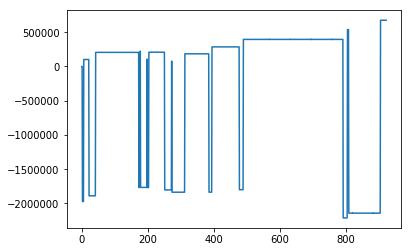

In [36]:
output = pd.DataFrame() #....final output to be stored in excel file
output['date'] = Data.index
output['Close'] = Data['future']
output['VIX'] = Data['VIX']
output['placed_order'] = Data['placed_order']
output['buy_sell'] = Data['buy_sell']
output['profit'] = Data['profit']
output['mtm'] = Data['mtm']
output['account'] = Data['out']
output['stoploss'] = Data['stoploss']
output.to_excel('VIX_SL_output.xlsx', sheet_name='Sheet1')

# plt.plot(Data['placed_order'] * 1000)
plt.plot(Data['out'])
plt.show()